# 初探keras

目前深度学习方向的软件框架已经足够让人眼花缭乱，对于开发者而言使用常用的、大众化的框架能够在遇到问题时节省很多时间。c++语言的常用框架是caffe，不过除了需要在嵌入式系统中使用深度学习之外，其他需求似乎并没有使用c++的必要，毕竟开发效率相对而言比较低。随着python流行度的增加，以python语言为基础的深度学习框架越来越普遍，其中为人们所熟知的是tensorflow和pytorch，这两个框架背后站台的公司分别是Google和Facebook。当然还有微软和亚马逊也推出了自己的框架，不过目前看来影响力稍弱。除了这些基础的框架外，还有一个依赖基础框架搭建而成的高层框架keras。目前keras官网支持的后端基础框架有tensorflow、CNTK和Theano。不过github上有一个plaidml仓库，提供了plaidml后端，使用这个后端的好处是可以在AMD的GPU上运行，特别对于Mac OS的用户来说是一种补救方案。下面就演示一下使用plaidml后端导入keras模块。

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import keras

Using plaidml.keras.backend backend.


## 1. 读取训练数据集

keras提供了一些常用数据集的载入接口，目前提供接口的数据集有：cifar、imdb、boston_housing和reuter。如果需要使用的数据集不在列表中，自己实现一下也很方便，最终就是将数据写入到numpy的数组中。下面演示一下载入mnist数据集。

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


<IPython.core.display.Javascript object>


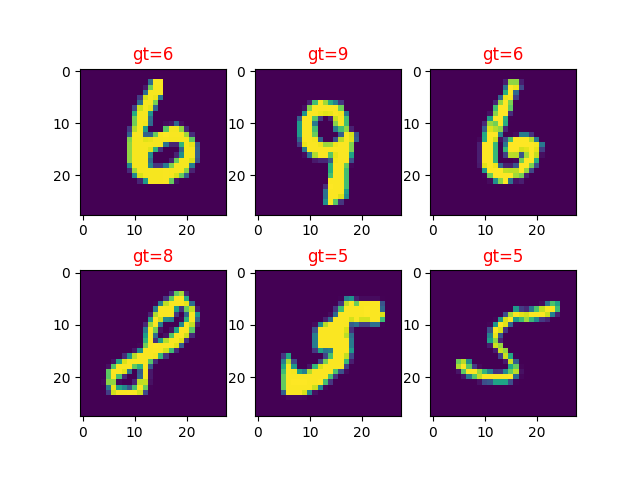

In [39]:
from keras.datasets import mnist
import math
xy_train, xy_test = mnist.load_data()
print(xy_train[0].shape, xy_train[1].shape)
print(xy_test[0].shape, xy_test[1].shape)
# 可视化部分训练数据
num_sam = xy_train[0].shape[0]
num_show = 6
index_arr = np.random.randint(0, num_sam, num_show)
plt.figure()
num_cols = 3
num_rows = math.ceil(num_show / 3)
for idx, index in enumerate(index_arr):
    plt.subplot(num_rows, num_cols, idx+1)
    plt.imshow(xy_train[0][index, ...])
    plt.title('gt={}'.format(str(xy_train[1][index])), c='r')
plt.show()

从可视化的结果来看，这个数据集是用于手写字符识别，数据集分为训练集和测试集，每个子集中包含若干张图片以及图片对应的数字标签。这个问题中机器学习模型的目的就是建议一个能够完成从图片到数字标签的映射，即输入图片，输出数字。从模型结构上看主要分成两大类，一是序贯式模型，即各种操作按顺序堆叠没有分支的模型；二是图式模型，即每个操作有输入和输出，可以允许计算流程出现分叉和聚合。

## 2. 序贯式模型

如果确认自己需要建模的目标可以使用序贯式模型实现，那么调用Sequential接口就非常方便。直接将各个操作层按顺序传入即可。

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Activation
# 构建模型
model = Sequential([Dense(32, input_shape=(784,)),
                   Activation('relu'),
                   Dense(10),
                   Activation('softmax'),])
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
# 准备数据，训练模型
X = np.reshape(xy_train[0], (-1, 784))
Y = keras.utils.to_categorical(xy_train[1], num_classes=10)
print(X.shape)
print(Y.shape)
model.fit(X, Y, epochs=10, batch_size=64)

(60000, 784)
(60000, 10)
Epoch 1/10
60000/60000 [==============================] - 4s 66us/step - loss: 2.0894 - acc: 0.7007
Epoch 2/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.7059 - acc: 0.8597
Epoch 3/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.5385 - acc: 0.8933
Epoch 4/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.4583 - acc: 0.9097
Epoch 5/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.4269 - acc: 0.9168
Epoch 6/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.3968 - acc: 0.9225
Epoch 7/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.3718 - acc: 0.9282
Epoch 8/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.3487 - acc: 0.9302
Epoch 9/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.3348 - acc: 0.9342
Epoch 10/10
60000/60000 [==============================] - 4s 66us/step - l

训练完成，发现损失函数在8个epochs之后就改善不大，因此训练过程已经收敛。最终在训练集上的精度是93.42%，这个结果在目前来看当然是很低的，主要原因是模型过于简单，不足以拟合这个数据集。可以增加模型的层数来达到更高的精度。接下来在测试集上评估一下模型的泛化能力。

In [41]:
# 使用测试集评估模型
XX = np.reshape(xy_test[0], [-1, 784])
YY = keras.utils.to_categorical(xy_test[1], num_classes=10)
model.evaluate(XX, YY, batch_size=64)

10000/10000 [==============================] - 1s 50us/step


[0.42029304790496824, 0.931]

测试集上的精度是93.1%，与训练精度93.42%相差不大，一般训练与测试相差10个百分点以内认为是并没有过拟合，当然数据极度不平衡除外。

## 3. 图式模型
序贯式模型虽然简单，但是对于一些复杂结构就没有办法实现了。因此keras还提供了另一种模式：函数式模型，也成图式模型。这种模型以函数的方式接受输入和产生输出。这样的话对于多输入多输出，图结构的中的分离和聚合就比较容易实现。下面演示的还是线性模型，只不过使用函数式的接口实现。

In [42]:
from keras.models import Model
from keras.layers import Dense, Activation, Input
# 构建模型
inputs = Input(shape=(784,))
fc1 = Dense(32)(inputs)
relu1 = Activation('relu')(fc1)
fc2 = Dense(10)(relu1)
sf2 = Activation('softmax')(fc2)
model = Model(inputs=inputs, outputs=sf2)
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
# 准备数据，训练模型
X = np.reshape(xy_train[0], (-1, 784))
Y = keras.utils.to_categorical(xy_train[1], num_classes=10)
print(X.shape)
print(Y.shape)
model.fit(X, Y, epochs=10, batch_size=64)

(60000, 784)
(60000, 10)
Epoch 1/10
60000/60000 [==============================] - 4s 67us/step - loss: 2.7947 - acc: 0.7481
Epoch 2/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.6994 - acc: 0.8621
Epoch 3/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.5614 - acc: 0.8911
Epoch 4/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.4827 - acc: 0.9051
Epoch 5/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.4323 - acc: 0.9142
Epoch 6/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.3897 - acc: 0.9206
Epoch 7/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.3814 - acc: 0.9252
Epoch 8/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.3457 - acc: 0.9294
Epoch 9/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.3330 - acc: 0.9343
Epoch 10/10
60000/60000 [==============================] - 4s 65us/step - l

训练完毕，最终结果跟序贯式并没有多大差别，毕竟模型是一致的，只是实现方式不太一样而已。下面在测试集上进行评估一下，发现测试结果和训练结果基本一致。

In [43]:
# 评估模型
XX = np.reshape(xy_test[0], [-1, 784])
YY = keras.utils.to_categorical(xy_test[1], num_classes=10)
model.evaluate(XX, YY, batch_size=64)

10000/10000 [==============================] - 0s 50us/step


[0.5102692862391471, 0.9245]

## 4. 预测结果展示

如果是将训练完成的模型投入到生产环境，就需要输入图片，然后预测输出，这里利用测试集模拟一下预测过程，然后可视化一些预测结果来检查一下。发现在绝大多数情况下，预测结果与真值是一致的，但是也有一些情况预测错误。事实上，在机器学习的模型中，这种概率性总是存在的，这样也就是说，越到后来精度越难以提供，所以如果一些项目的精度已经到95%以上，基本意味着这个项目改善的空间也不大了。

(10000, 10)
(10000,)


<IPython.core.display.Javascript object>


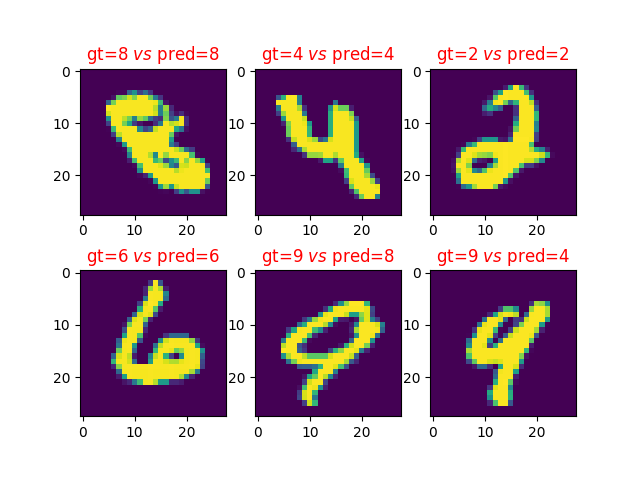

In [45]:
# 使用测试集进行预测
pred_YY = model.predict(XX)
print(pred_YY.shape)
pred_test = np.argmax(pred_YY, axis=1)
print(pred_test.shape)
# 可视化测试集上的部分数据真值与预测值
num_sam = xy_test[0].shape[0]
num_show = 6
index_arr = np.random.randint(0, num_sam, num_show)
plt.figure()
num_cols = 3
num_rows = math.ceil(num_show / 3)
for idx, index in enumerate(index_arr):
    plt.subplot(num_rows, num_cols, idx+1)
    plt.imshow(xy_test[0][index, ...])
    plt.title('gt={} $vs$ pred={}'.format(str(xy_test[1][index]), str(pred_test[index])), c='r')
plt.show()

到此，对于keras的初步认识就完成了。从arxiv上论文提及的框架来看，keras的热度已经超过了pytorch，仅次于tensorflow。随着时间的发展，以及keras支持的后端越来越多，会有更多的科研工作者或者算法原型的开发者使用keras，毕竟没有人会跟便捷高效过不去。本文的notebook版本文件在github上cnbluegeek/notebook仓库中共享，欢迎感兴趣的朋友下载。